### База

In [1]:
import re
import json
import warnings
import random
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [2]:
dataset = load_dataset("ai4privacy/pii-masking-200k")

def explore_dataset(dataset):
    print(f"Dataset type: {type(dataset)}")
    print(f"Dataset keys: {list(dataset.keys())}")
    
    for split in dataset.keys():
        print(f"Number of samples: {len(dataset[split])}")
        print(f"Features: {list(dataset[split].features.keys())}")
        for key, value in dataset[split][0].items():
            print(f"  {key}: {str(value)[:200]}")

README.md: 0.00B [00:00, ?B/s]

english_pii_43k.jsonl:   0%|          | 0.00/73.8M [00:00<?, ?B/s]

french_pii_62k.jsonl:   0%|          | 0.00/116M [00:00<?, ?B/s]

german_pii_52k.jsonl:   0%|          | 0.00/97.8M [00:00<?, ?B/s]

italian_pii_50k.jsonl:   0%|          | 0.00/93.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/209261 [00:00<?, ? examples/s]

In [3]:
explore_dataset(dataset)

Dataset type: <class 'datasets.dataset_dict.DatasetDict'>
Dataset keys: ['train']
Number of samples: 209261
Features: ['source_text', 'target_text', 'privacy_mask', 'span_labels', 'mbert_text_tokens', 'mbert_bio_labels', 'id', 'language', 'set']
  source_text: A student's assessment was found on device bearing IMEI: 06-184755-866851-3. The document falls under the various topics discussed in our Optimization curriculum. Can you please collect it?
  target_text: A student's assessment was found on device bearing IMEI: [PHONEIMEI]. The document falls under the various topics discussed in our [JOBAREA] curriculum. Can you please collect it?
  privacy_mask: [{'value': '06-184755-866851-3', 'start': 57, 'end': 75, 'label': 'PHONEIMEI'}, {'value': 'Optimization', 'start': 138, 'end': 150, 'label': 'JOBAREA'}]
  span_labels: [[0, 57, "O"], [57, 75, "PHONEIMEI"], [75, 138, "O"], [138, 150, "JOBAREA"], [150, 189, "O"]]
  mbert_text_tokens: ['A', 'student', "'", 's', 'assessment', 'was', 'found'

In [4]:
def dataset_to_dataframe(dataset, split: str = 'train', sample_size: int = 50000):
    if len(dataset[split]) > sample_size:
        sampled_data = dataset[split].shuffle(seed=42).select(range(sample_size))
    else:
        sampled_data = dataset[split]
    
    df = pd.DataFrame(sampled_data)

    return df

df = dataset_to_dataframe(dataset)
print(f"DataFrame shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

DataFrame shape: (50000, 9)
Columns: ['source_text', 'target_text', 'privacy_mask', 'span_labels', 'mbert_text_tokens', 'mbert_bio_labels', 'id', 'language', 'set']


In [5]:
def basic_analysis(df: pd.DataFrame):
    print(f"Total records: {len(df):,}")
    print(f"Columns: {df.columns.tolist()}")
    
    info_df = pd.DataFrame({
        'column': df.columns,
        'dtype': df.dtypes,
        'non_null_count': df.count(),
        'null_count': df.isnull().sum(),
        'null_percentage': (df.isnull().sum() / len(df)) * 100
    })
    print(info_df)
    
    if 'text' in df.columns:
        df['text_length'] = df['text'].str.len()
        df['word_count'] = df['text'].str.split().str.len()
        
        text_stats = df['text_length'].describe()
        word_stats = df['word_count'].describe()
        
        print("Text Length Statistics:")
        print(text_stats)
        print("\nWord Count Statistics:")
        print(word_stats)
    
    if 'label' in df.columns:
        label_dist = df['label'].value_counts()
        print(label_dist)
        
        plt.figure(figsize=(10, 6))
        label_dist.head(20).plot(kind='bar')
        plt.title('Top 20 Label Distribution')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    return df

In [6]:
df = basic_analysis(df)

Total records: 50,000
Columns: ['source_text', 'target_text', 'privacy_mask', 'span_labels', 'mbert_text_tokens', 'mbert_bio_labels', 'id', 'language', 'set']
                              column   dtype  non_null_count  null_count  \
source_text              source_text  object           50000           0   
target_text              target_text  object           50000           0   
privacy_mask            privacy_mask  object           50000           0   
span_labels              span_labels  object           50000           0   
mbert_text_tokens  mbert_text_tokens  object           50000           0   
mbert_bio_labels    mbert_bio_labels  object           50000           0   
id                                id   int64           50000           0   
language                    language  object           50000           0   
set                              set  object           50000           0   

                   null_percentage  
source_text                    0.0  
target

### Простой анализ сырых текстов

In [7]:
def text_quality_analysis(df):    
    if 'source_text' not in df.columns:
        print("No 'source_text' column found")
        return
    
    df['has_special_chars'] = df['source_text'].apply(lambda x: bool(re.search(r'[^a-zA-Z0-9\s\.\,\!\?]', str(x))))
    df['has_numbers'] = df['source_text'].apply(lambda x: bool(re.search(r'\d', str(x))))
    df['has_uppercase'] = df['source_text'].apply(lambda x: bool(re.search(r'[A-Z]', str(x))))
    df['has_urls'] = df['source_text'].apply(
        lambda x: bool(re.search(
            r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
            str(x)
        ))
    )
    df['has_emails'] = df['source_text'].apply(lambda x: bool(re.search(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', str(x))))
    
    quality_metrics = {
        'Contains Special Characters': df['has_special_chars'].mean() * 100,
        'Contains Numbers': df['has_numbers'].mean() * 100,
        'Contains Uppercase': df['has_uppercase'].mean() * 100,
        'Contains URLs': df['has_urls'].mean() * 100,
        'Contains Emails': df['has_emails'].mean() * 100
    }
    
    print("Text Quality Metrics (% of texts containing):")
    for metric, value in quality_metrics.items():
        print(f"{metric}: {value:.2f}%")
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    df['text_length'] = df['source_text'].str.len()
    axes[0].hist(df['text_length'], bins=50, alpha=0.7, color='skyblue')
    axes[0].set_xlabel('Text Length (characters)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Text Lengths')
    axes[0].axvline(df['text_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["text_length"].mean():.1f}')
    axes[0].legend()

    df['word_count'] = df['source_text'].str.split().str.len()
    axes[1].hist(df['word_count'], bins=50, alpha=0.7, color='lightgreen')
    axes[1].set_xlabel('Word Count')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of Word Counts')
    axes[1].axvline(df['word_count'].mean(), color='red', linestyle='--', label=f'Mean: {df["word_count"].mean():.1f}')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return df

Text Quality Metrics (% of texts containing):
Contains Special Characters: 91.37%
Contains Numbers: 88.58%
Contains Uppercase: 99.97%
Contains URLs: 5.83%
Contains Emails: 8.52%


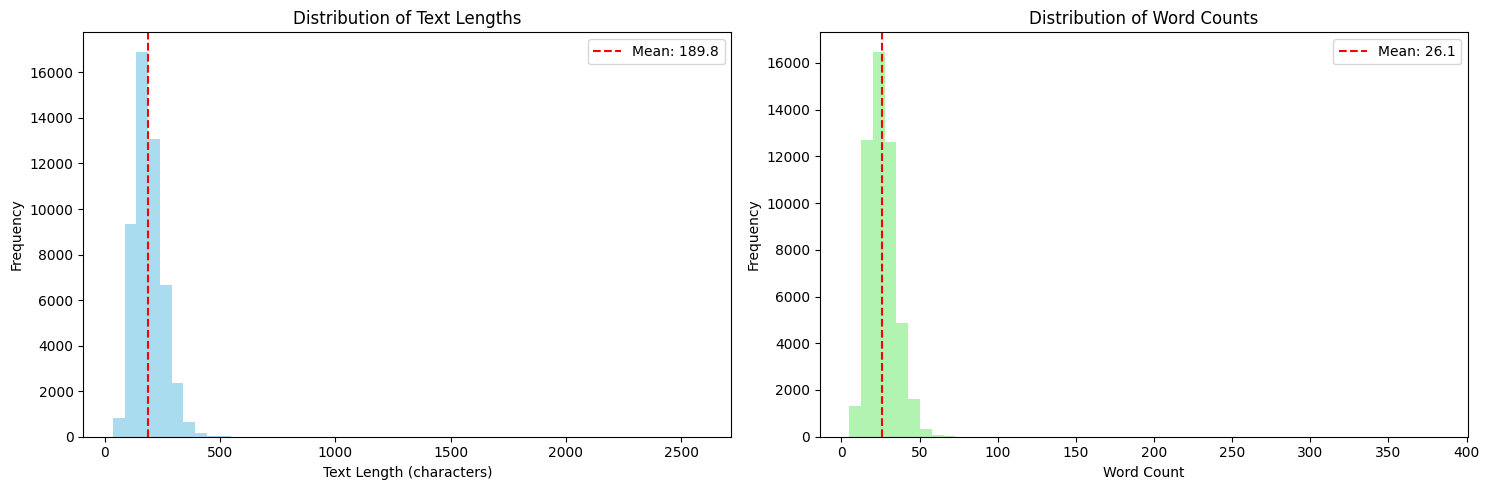

In [8]:
df = text_quality_analysis(df)

Тексты достаточно короткие и могут быть обработаны даже относительно простыми энкодерами, например, классическим BERT

### Длины текстов по языкам

In [9]:
def plot_language_distributions(df):
    df['text_length'] = df['source_text'].str.len()
    df['word_count'] = df['source_text'].str.split().str.len()
    df['avg_word_length'] = df['source_text'].apply(
        lambda x: np.mean([len(word) for word in str(x).split()]) if str(x).split() else 0
    )
    
    language_counts = df['language'].value_counts()
    top_languages = language_counts.head(10).index.tolist()
    
    df_top_langs = df[df['language'].isin(top_languages)]
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    sns.boxplot(data=df_top_langs, x='language', y='word_count', ax=axes[0, 0])
    axes[0, 0].set_title('Word Count Distribution by Language', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Language')
    axes[0, 0].set_ylabel('Word Count')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    sns.boxplot(data=df_top_langs, x='language', y='avg_word_length', ax=axes[0, 1])
    axes[0, 1].set_title('Average Word Length Distribution by Language', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Language')
    axes[0, 1].set_ylabel('Average Word Length (characters)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    sns.boxplot(data=df_top_langs, x='language', y='text_length', ax=axes[1, 0])
    axes[1, 0].set_title('Text Length Distribution by Language', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Language')
    axes[1, 0].set_ylabel('Text Length (characters)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    language_counts.head(10).plot(kind='bar', ax=axes[1, 1], color='lightcoral')
    axes[1, 1].set_title('Top 10 Languages by Sample Count', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Language')
    axes[1, 1].set_ylabel('Number of Samples')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    for i, (lang, count) in enumerate(language_counts.head(10).items()):
        axes[1, 1].text(i, count + (count * 0.01), f'{count:,}', 
                       ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    lang_stats = df_top_langs.groupby('language').agg({
        'word_count': ['mean', 'median', 'std', 'min', 'max'],
        'avg_word_length': ['mean', 'median', 'std'],
        'text_length': ['mean', 'median', 'std']
    }).round(2)
    
    print(lang_stats)
    
    return df

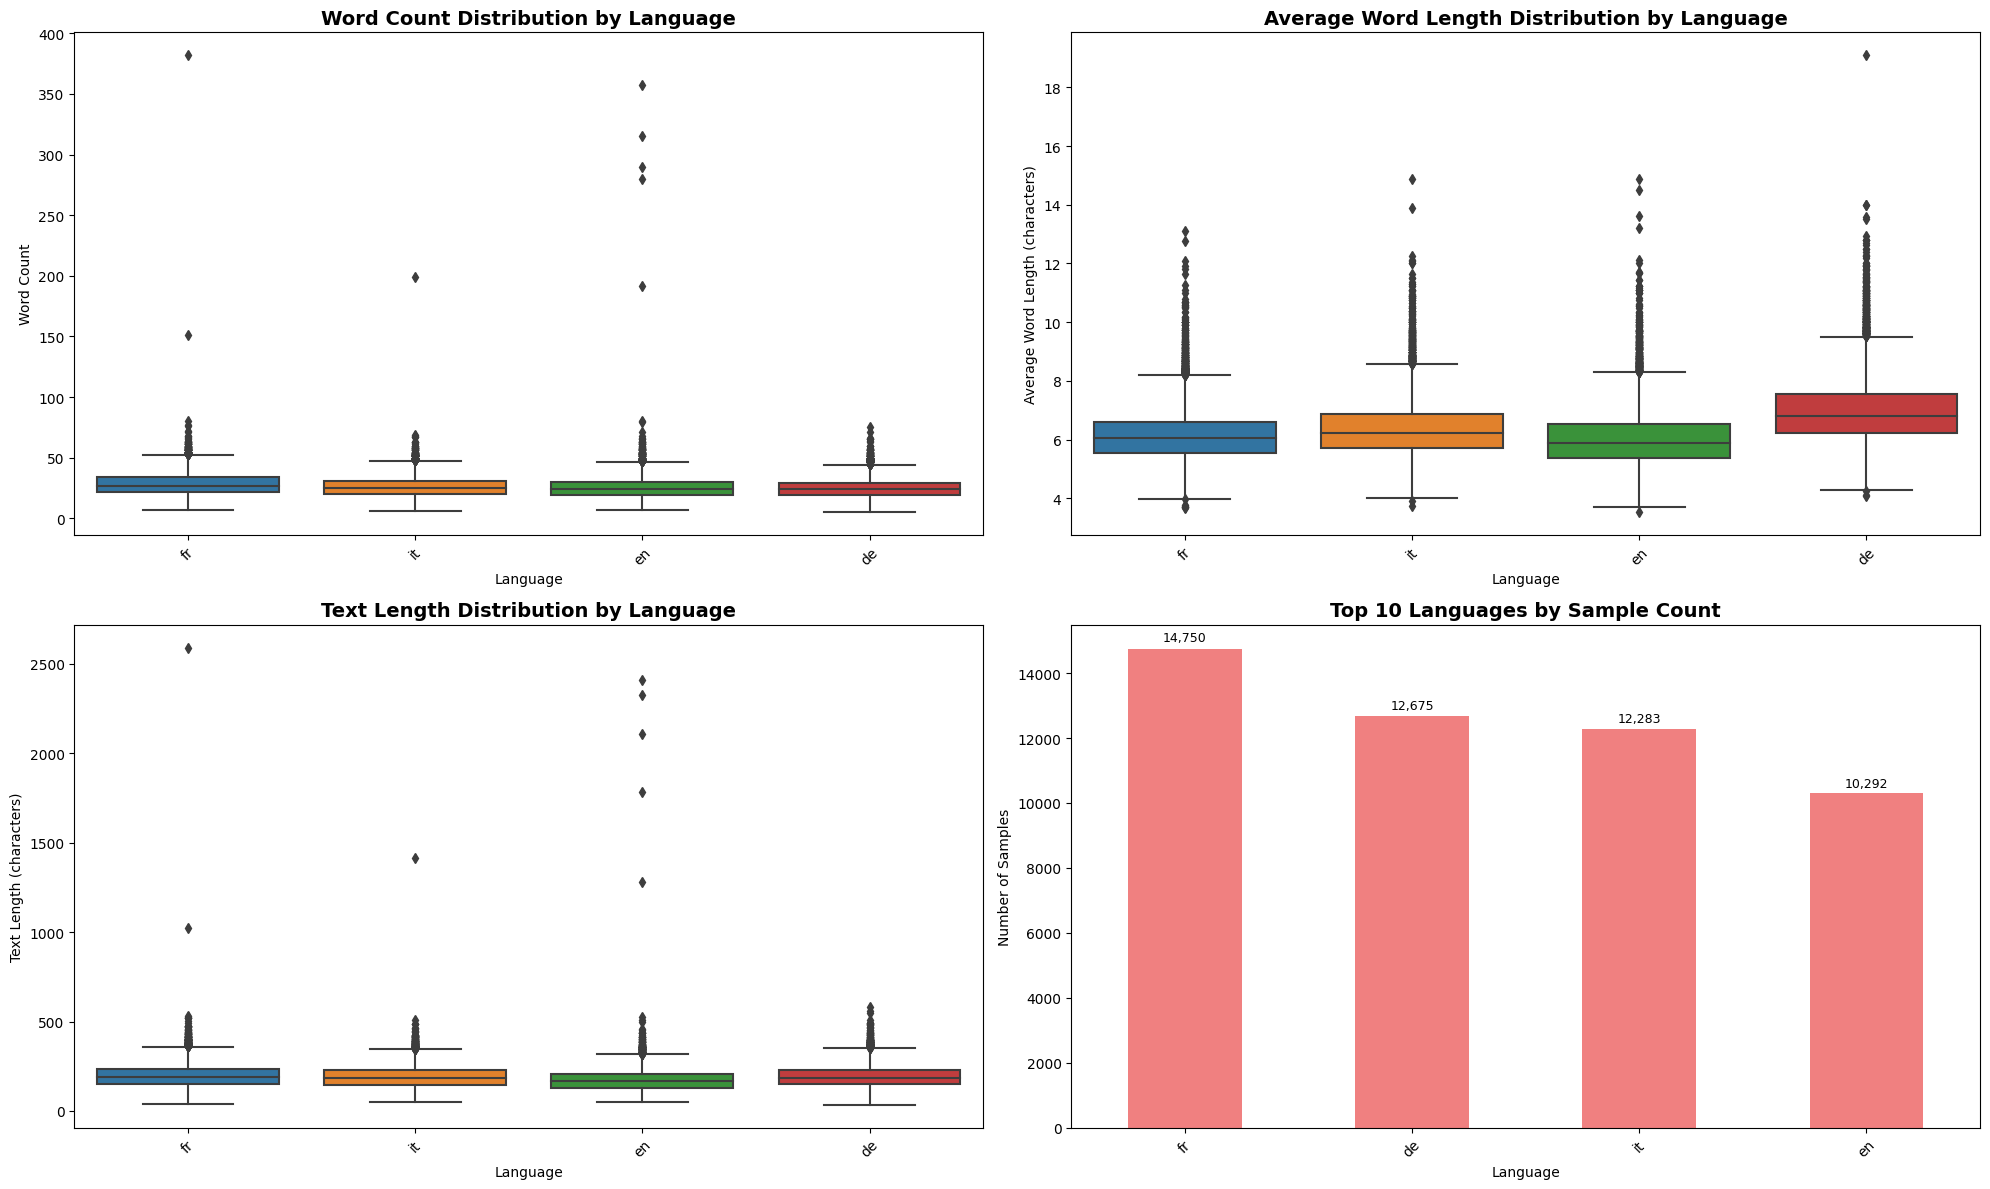

         word_count                        avg_word_length               \
               mean median    std min  max            mean median   std   
language                                                                  
de            24.58   24.0   8.05   5   75            6.97   6.81  1.10   
en            25.01   24.0  10.16   7  357            6.05   5.89  1.00   
fr            28.08   27.0   9.33   7  382            6.14   6.04  0.87   
it            26.30   25.0   8.41   6  199            6.36   6.22  0.95   

         text_length                
                mean median    std  
language                            
de            192.71  185.0  61.98  
en            173.15  165.0  69.63  
fr            198.09  190.0  65.83  
it            190.85  184.0  61.02  


,source_text,target_text,privacy_mask,span_labels,mbert_text_tokens,mbert_bio_labels,id,language,set,has_special_chars,has_numbers,has_uppercase,has_urls,has_emails,text_length,word_count,avg_word_length
0,Mise à jour : l'heure de début de la thérapie ...,Mise à jour : l'heure de début de la thérapie ...,"[{'value': '8:46 AM', 'start': 72, 'end': 79, ...","[[0, 72, ""O""], [72, 79, ""TIME""], [79, 88, ""O""]...","[Mis, ##e, à, jour, :, l, ', heure, de, début,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",19053,fr,train,True,True,True,False,False,155,29,4.379310
1,"Dans le comté de Cleveland, le conseil scolair...","Dans le comté de [COUNTY], le conseil scolaire...","[{'value': 'Cleveland', 'start': 17, 'end': 26...","[[0, 17, ""O""], [17, 26, ""COUNTY""], [26, 196, ""...","[Dans, le, comté, de, Cleveland, ,, le, consei...","[O, O, O, O, B-COUNTY, O, O, O, O, O, O, O, O,...",52304,fr,train,True,False,True,True,False,291,39,6.487179
2,Abbiamo effettuato un intervento chirurgico su...,Abbiamo effettuato un intervento chirurgico su...,"[{'value': 'Female to male transsexual man', '...","[[0, 47, ""O""], [47, 77, ""GENDER""], [77, 87, ""O...","[Ab, ##bia, ##mo, effet, ##tua, ##to, un, inte...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-GEND...",64039,it,train,True,True,True,False,False,98,14,6.071429
3,"Salut Alysa, nous nous préparons pour notre co...","Salut [FIRSTNAME], nous nous préparons pour no...","[{'value': 'Alysa', 'start': 6, 'end': 11, 'la...","[[0, 6, ""O""], [6, 11, ""FIRSTNAME""], [11, 102, ...","[Sal, ##ut, Al, ##ys, ##a, ,, nous, nous, pré,...","[O, O, B-FIRSTNAME, I-FIRSTNAME, I-FIRSTNAME, ...",39437,fr,train,True,True,True,True,False,299,39,6.692308
4,Il nostro team esterno per Creative sta lavora...,Il nostro team esterno per [JOBAREA] sta lavor...,"[{'value': 'Creative', 'start': 27, 'end': 35,...","[[0, 27, ""O""], [27, 35, ""JOBAREA""], [35, 122, ...","[Il, nos, ##tro, team, esterno, per, Creative,...","[O, O, O, O, O, O, B-JOBAREA, O, O, O, O, O, O...",73612,it,train,True,True,True,False,False,187,24,6.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,Stiamo organizzando una raccolta fondi per mig...,Stiamo organizzando una raccolta fondi per mig...,"[{'value': 'Avon', 'start': 100, 'end': 104, '...","[[0, 100, ""O""], [100, 104, ""COUNTY""], [104, 14...","[St, ##iamo, organi, ##zza, ##ndo, una, raccol...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",86718,it,train,True,True,True,False,False,227,29,6.862069
49996,"Ciao Rolando, condividi il codice di accesso 7...","Ciao [FIRSTNAME], condividi il codice di acces...","[{'value': 'Rolando', 'start': 5, 'end': 12, '...","[[0, 5, ""O""], [5, 12, ""FIRSTNAME""], [12, 45, ""...","[Ci, ##ao, Roland, ##o, ,, con, ##di, ##vid, #...","[O, O, B-FIRSTNAME, I-FIRSTNAME, O, O, O, O, O...",79432,it,train,False,True,True,False,False,93,17,4.529412
49997,"Grüße, wir führen umfangreiche Forschungen zur...","Grüße, wir führen umfangreiche Forschungen zur...","[{'value': 'Female', 'start': 123, 'end': 129,...","[[0, 123, ""O""], [123, 129, ""SEX""], [129, 188, ...","[G, ##rü, ##ße, ,, wir, führen, umfangreiche, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",143523,de,train,True,True,True,False,False,210,28,6.535714
49998,Alle hier im Büro in Leicestershire freuen sic...,"Alle hier im Büro in [COUNTY] freuen sich, das...","[{'value': 'Leicestershire', 'start': 21, 'end...","[[0, 21, ""O""], [21, 35, ""COUNTY""], [35, 71, ""O...","[Alle, hier, im, Büro, in, Leicester, ##shire,...","[O, O, O, O, O, B-COUNTY, I-COUNTY, O, O, O, O...",121383,de,train,True,False,True,False,False,111,20,4.600000


In [10]:
plot_language_distributions(df)

Относительно языков длины текстов распределены достаточно равномерно. Особого смысла выравнивать тексты по языкам - нет

### Распределения PII-сущностей

#### Без учета языка

In [11]:
def plot_pii_label_distribution(df: pd.DataFrame, top_n: int = 20):
    all_labels = []
    label_counts_per_text = []
    
    for mask_list in df['privacy_mask']:
        if isinstance(mask_list, list):
            labels_in_text = []
            for mask in mask_list:
                if isinstance(mask, dict) and 'label' in mask:
                    all_labels.append(mask['label'])
                    labels_in_text.append(mask['label'])
            label_counts_per_text.append(len(labels_in_text))
        else:
            label_counts_per_text.append(0)
    
    df['pii_label_count'] = label_counts_per_text
    
    label_counter = Counter(all_labels)
    total_labels = len(all_labels)
    total_texts = len(df)
    texts_with_pii = (df['pii_label_count'] > 0).sum()
    
    print(f"Total PII labels found: {total_labels:,}")
    print(f"Total texts: {total_texts:,}")
    print(f"Texts with at least one PII: {texts_with_pii:,} ({texts_with_pii/total_texts*100:.2f}%)")
    print(f"Average PII labels per text: {total_labels/total_texts:.2f}")
    print(f"Average PII labels in texts with PII: {total_labels/texts_with_pii:.2f}")
    
    fig, axes = plt.subplots(3, 1, figsize=(20, 18))
    
    top_labels = label_counter.most_common(top_n)
    labels, counts = zip(*top_labels)
    
    bars = axes[0].bar(range(len(labels)), counts, color='skyblue', alpha=0.7)
    axes[0].set_title(f'Top {top_n} PII Label Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('PII Label Types')
    axes[0].set_ylabel('Frequency')
    axes[0].set_xticks(range(len(labels)))
    axes[0].set_xticklabels(labels, rotation=45, ha='right')
    
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + (height * 0.01),
                       f'{count:,}', ha='center', va='bottom', fontsize=9)
    
    pii_count_dist = Counter(label_counts_per_text)
    counts, frequencies = zip(*sorted(pii_count_dist.items()))
    
    axes[1].bar(counts, frequencies, color='lightgreen', alpha=0.7)
    axes[1].set_title('Distribution of PII Labels per Text', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Number of PII Labels in Text')
    axes[1].set_ylabel('Number of Texts')
    
    total = sum(frequencies)
    for i, (count, freq) in enumerate(zip(counts, frequencies)):
        percentage = (freq / total) * 100
        axes[1].text(count, freq + (freq * 0.01), f'{percentage:.1f}%', 
                       ha='center', va='bottom', fontsize=9)
    
    label_percentages = [(label, count/total_labels * 100) for label, count in top_labels]
    labels, percentages = zip(*label_percentages)
    
    axes[2].pie(percentages, labels=labels, autopct='%1.1f%%', startangle=90)
    axes[2].set_title(f'Top {top_n} PII Label Percentage Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    for i, (label, count) in enumerate(top_labels, 1):
        percentage = (count / total_labels) * 100
        print(f"{i:2d}. {label:<20} {count:>8,} ({percentage:6.2f}%)")
    
    return df, label_counter

Total PII labels found: 154,794
Total texts: 50,000
Texts with at least one PII: 50,000 (100.00%)
Average PII labels per text: 3.10
Average PII labels in texts with PII: 3.10


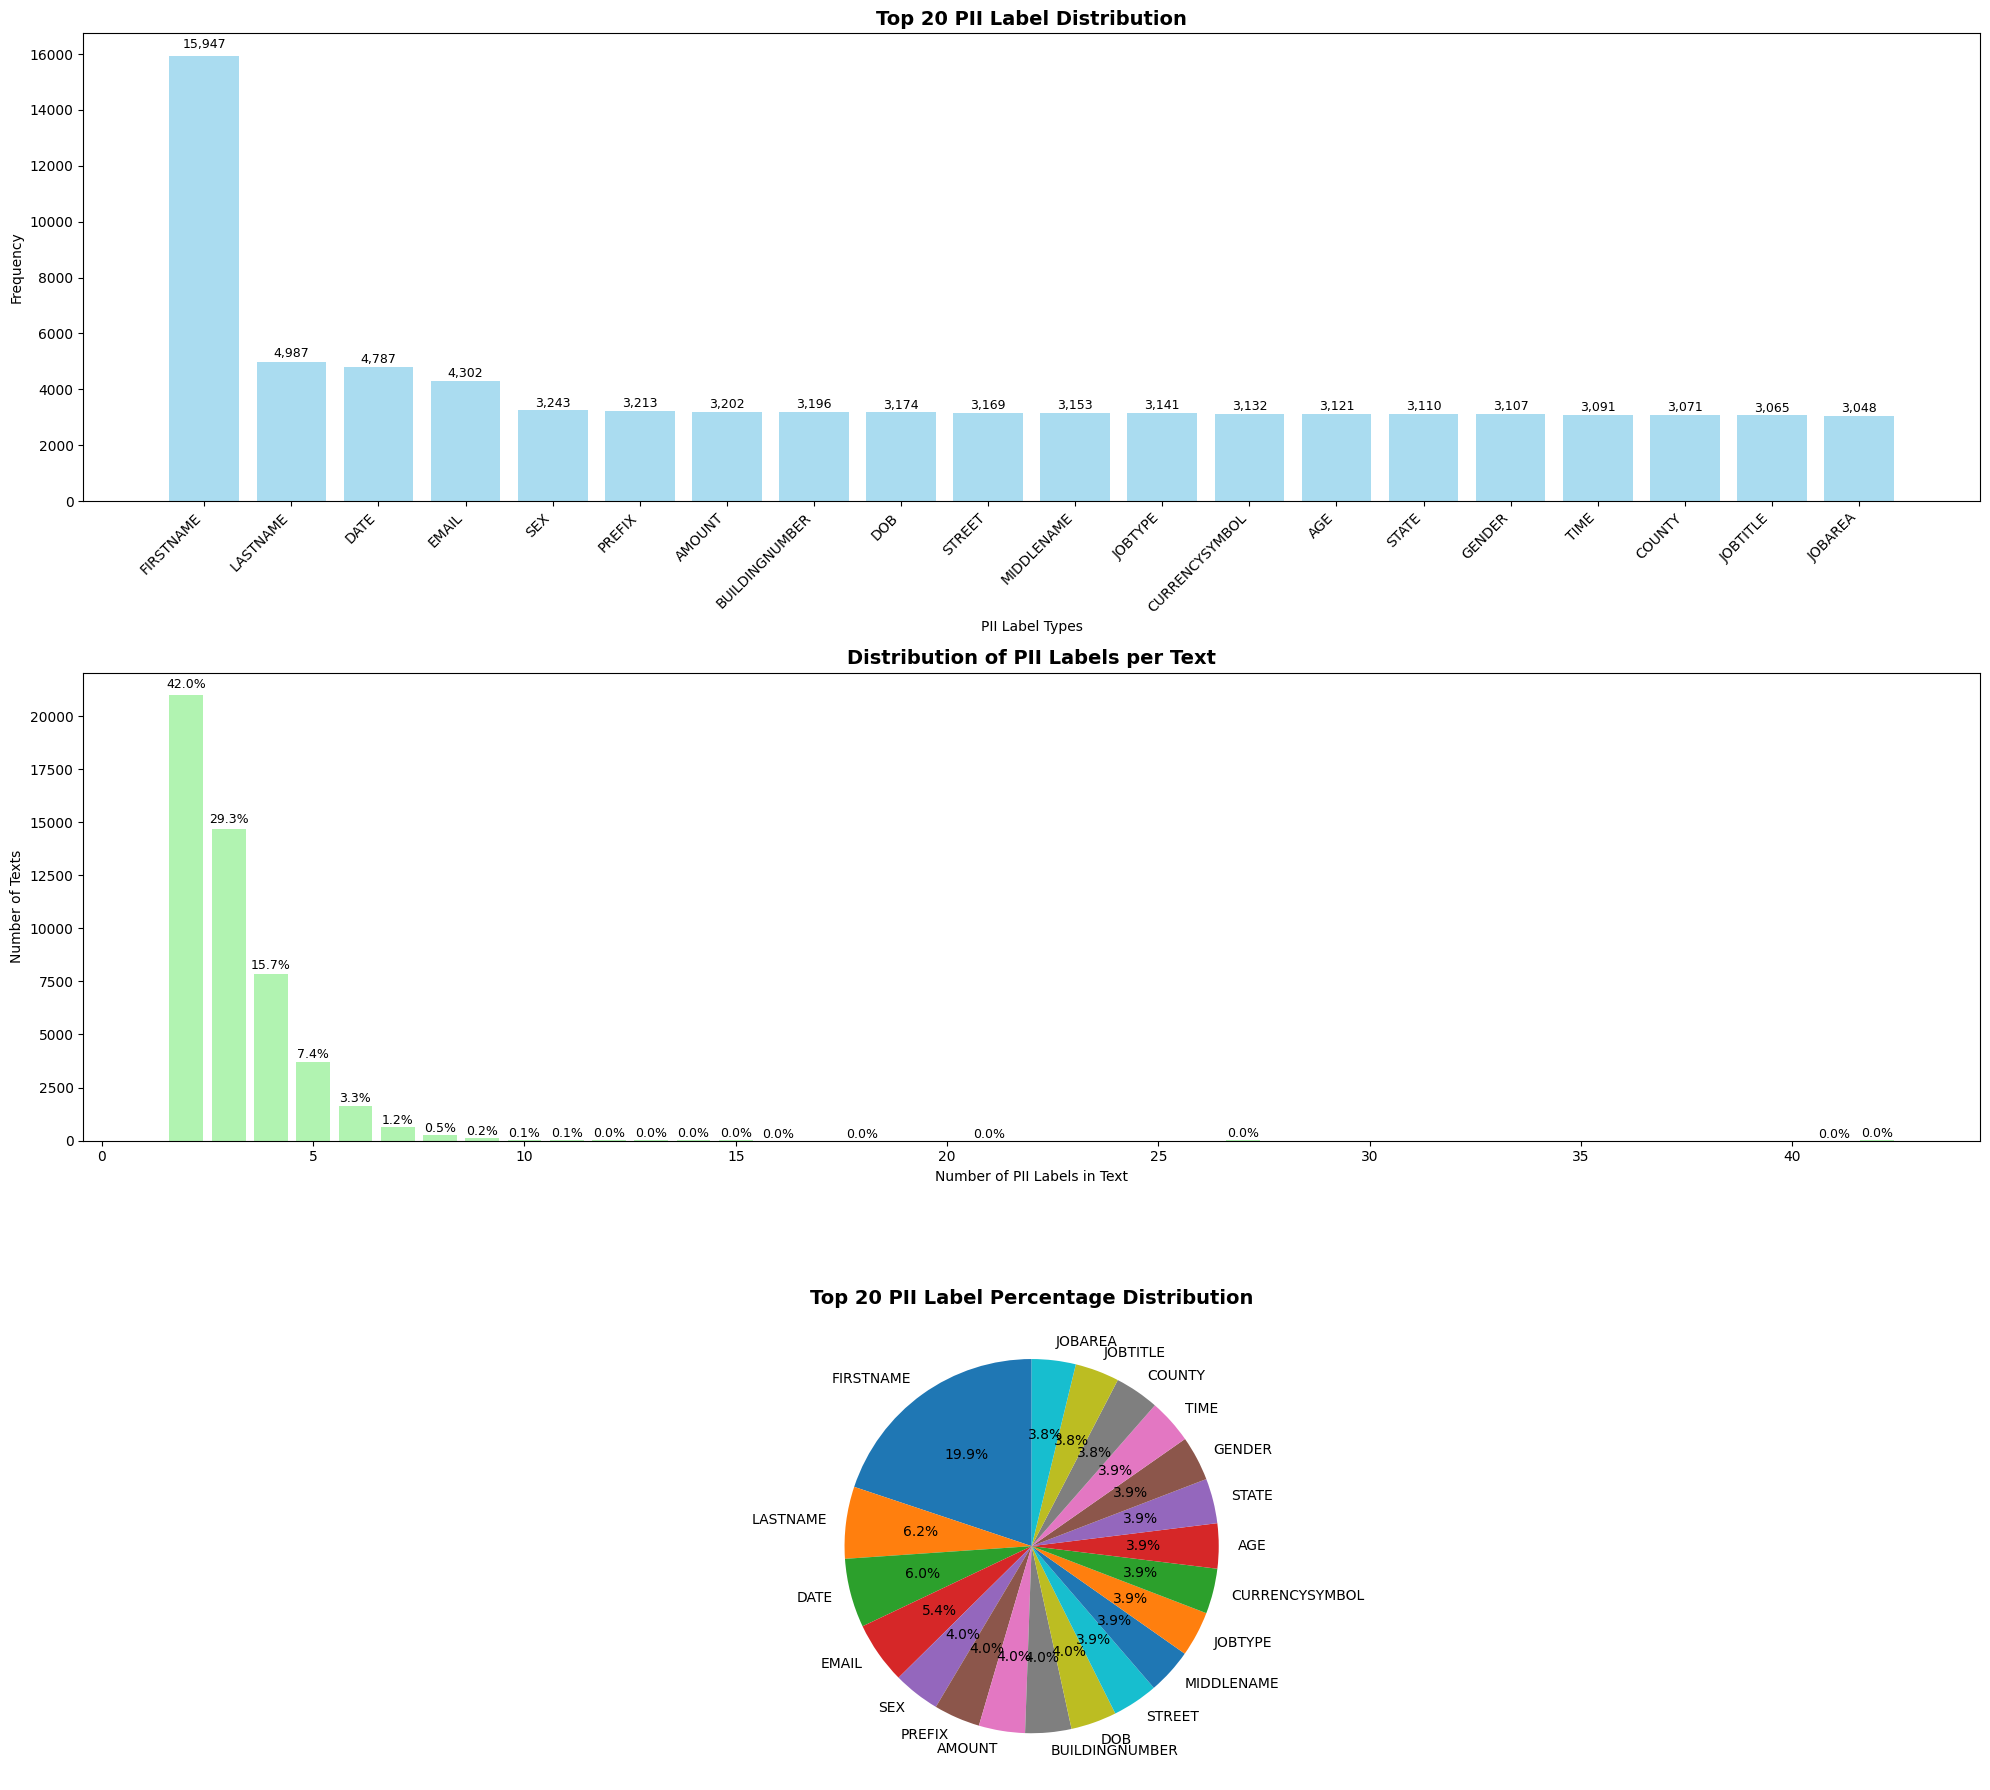

 1. FIRSTNAME              15,947 ( 10.30%)
 2. LASTNAME                4,987 (  3.22%)
 3. DATE                    4,787 (  3.09%)
 4. EMAIL                   4,302 (  2.78%)
 5. SEX                     3,243 (  2.10%)
 6. PREFIX                  3,213 (  2.08%)
 7. AMOUNT                  3,202 (  2.07%)
 8. BUILDINGNUMBER          3,196 (  2.06%)
 9. DOB                     3,174 (  2.05%)
10. STREET                  3,169 (  2.05%)
11. MIDDLENAME              3,153 (  2.04%)
12. JOBTYPE                 3,141 (  2.03%)
13. CURRENCYSYMBOL          3,132 (  2.02%)
14. AGE                     3,121 (  2.02%)
15. STATE                   3,110 (  2.01%)
16. GENDER                  3,107 (  2.01%)
17. TIME                    3,091 (  2.00%)
18. COUNTY                  3,071 (  1.98%)
19. JOBTITLE                3,065 (  1.98%)
20. JOBAREA                 3,048 (  1.97%)


In [12]:
df, label_counter = plot_pii_label_distribution(df)

Из всех PII сущеностей выделяется `FIRSTNAME`, но в целом перекос не очень сильный. Остальные сущности распределены относительно равномерно без учета языка. В идеале данные можно было бы стратифицировать по PII labels, но кажется это не критично

#### С учетом языка

In [13]:
def plot_label_distribution_by_language(df, label_counter, top_labels=10, top_languages=5):
    top_langs = df['language'].value_counts().head(top_languages).index.tolist()
    top_label_types = [label for label, _ in label_counter.most_common(top_labels)]
    
    lang_label_matrix = {}
    
    for lang in top_langs:
        lang_data = df[df['language'] == lang]
        lang_labels = []
        
        for mask_list in lang_data['privacy_mask']:
            if isinstance(mask_list, list):
                for mask in mask_list:
                    if isinstance(mask, dict) and 'label' in mask:
                        lang_labels.append(mask['label'])
        
        label_counts = Counter(lang_labels)
        lang_label_matrix[lang] = label_counts
    
    fig, axes = plt.subplots(3, 1, figsize=(20, 20))
    
    label_data = {label: [lang_label_matrix[lang].get(label, 0) for lang in top_langs] 
                  for label in top_label_types}
    
    x = range(len(top_langs))
    bottom = np.zeros(len(top_langs))
    
    for i, label in enumerate(top_label_types):
        axes[0].bar(x, label_data[label], bottom=bottom, label=label, alpha=0.8)
        bottom += label_data[label]
    
    axes[0].set_title(f'Top {top_labels} PII Label Distribution by Language', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Language')
    axes[0].set_ylabel('Frequency')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(top_langs)
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    normalized_data = {}
    for lang in top_langs:
        total = sum(lang_label_matrix[lang].values())
        if total > 0:
            normalized_data[lang] = {label: count/total * 100 for label, count in lang_label_matrix[lang].items()}
        else:
            normalized_data[lang] = {}
    
    x = np.arange(len(top_label_types))
    width = 0.15
    
    for i, lang in enumerate(top_langs):
        lang_values = [normalized_data[lang].get(label, 0) for label in top_label_types]
        axes[1].bar(x + i*width, lang_values, width, label=lang, alpha=0.7)
    
    axes[1].set_title(f'Normalized PII Label Distribution by Language (%)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('PII Label Types')
    axes[1].set_ylabel('Percentage (%)')
    axes[1].set_xticks(x + width*(top_languages-1)/2)
    axes[1].set_xticklabels(top_label_types, rotation=45)
    axes[1].legend()
    
    lang_pii_density = []
    for lang in top_langs:
        lang_data = df[df['language'] == lang]
        total_labels = sum(len([mask for mask in masks if isinstance(mask, dict) and 'label' in mask]) 
                          for masks in lang_data['privacy_mask'] if isinstance(masks, list))
        total_texts = len(lang_data)
        lang_pii_density.append(total_labels / total_texts if total_texts > 0 else 0)
    
    axes[2].bar(top_langs, lang_pii_density, color='orange', alpha=0.7)
    axes[2].set_title('Average PII Labels per Text by Language', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Language')
    axes[2].set_ylabel('Average PII Labels per Text')
    axes[2].tick_params(axis='x', rotation=45)
    
    for i, density in enumerate(lang_pii_density):
        axes[2].text(i, density + 0.01, f'{density:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nPII Statistics by Language:")
    print(f"{'Language':<12} {'Samples':<8} {'Texts with PII':<15} {'PII Labels':<12} {'Avg PII/Text':<12}")
    
    for lang in top_langs:
        lang_data = df[df['language'] == lang]
        total_texts = len(lang_data)
        texts_with_pii = sum(1 for masks in lang_data['privacy_mask'] 
                           if isinstance(masks, list) and len(masks) > 0)
        total_labels = sum(len([mask for mask in masks if isinstance(mask, dict) and 'label' in mask]) 
                          for masks in lang_data['privacy_mask'] if isinstance(masks, list))
        avg_pii_per_text = total_labels / total_texts if total_texts > 0 else 0
        
        print(f"{lang:<12} {total_texts:<8} {texts_with_pii:<15} {total_labels:<12} {avg_pii_per_text:<12.2f}")

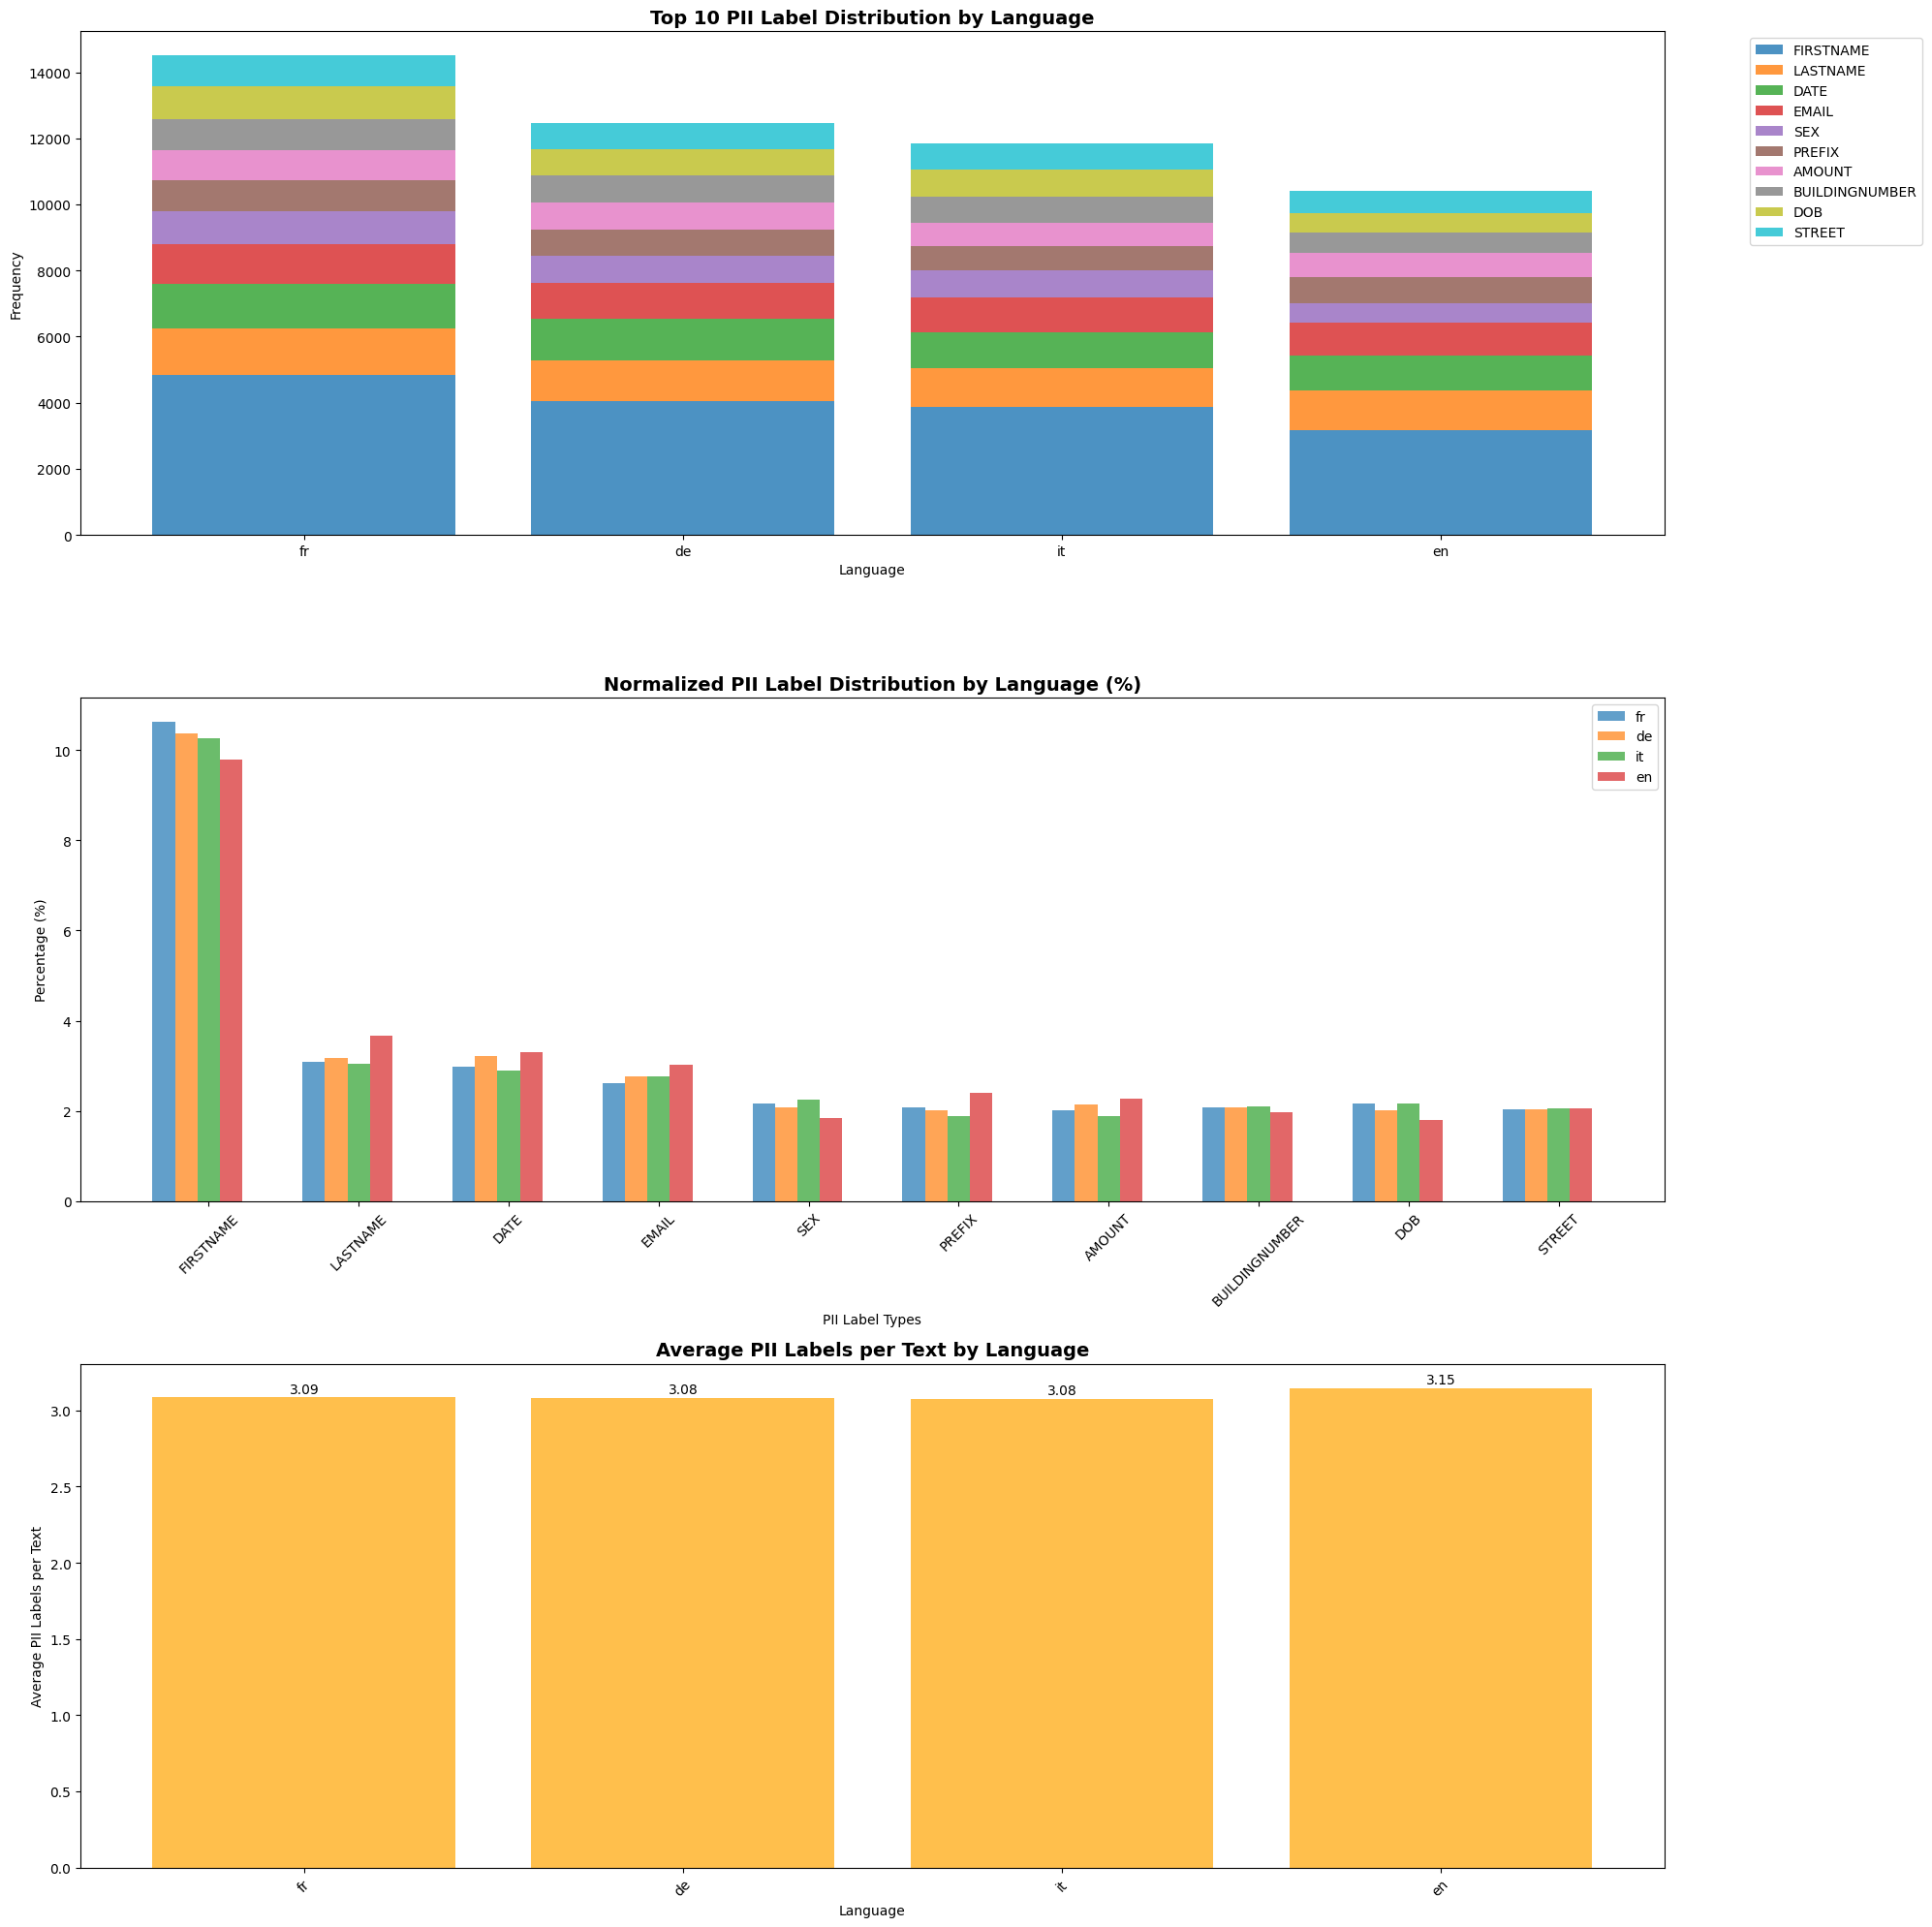


PII Statistics by Language:
Language     Samples  Texts with PII  PII Labels   Avg PII/Text
fr           14750    14750           45521        3.09        
de           12675    12675           39070        3.08        
it           12283    12283           37805        3.08        
en           10292    10292           32398        3.15        


In [14]:
plot_label_distribution_by_language(df, label_counter)

Если рассматривать каждый язык по отдельности, то в целом распределение PII сущностей более менее одинаковое

### Выводы

Датасет достаточно качественный и практически не нуждается в предобработке. Все сэмплы полезные, т.е. тексты без единого PII отсутствуют. Тексты относительно короткие, не больше размера контекста даже маленьких моделей (например на 512 токенов). PII сущностей среднее количество. Длины текстов распределены более менее равномерно и одинаково как между языков, так и внутри. PII сущности также распределены относительно равномерно как без учета языка, так и беря его во внимание, за исключением FIRSTNAME - в идеале делать стратификацию при разделении выборки.
В целом, для такой задачи подойдет любой хороший предобученный на английском, итальянском, немецком и французском языках трансформер с длиной контекста от 512 токенов. Особо большие модели брать смысла нет, они попросту будут переобучиваться. Количество текстов достаточно большое (200k+), так что трансформеры вероятно будут наиболее подходящими